(greenhouse:exercise)=
# Greenhouse model

**Task 1**: Plug Eq. (7) into Eq. (6) and solve for the radiative equilibrium suface temperature $T_e$ 

In [1]:
# Solve for the radiative equilibrium temperature Te
# Put you own code here
alpha = .3
Q = 342
sigma = 5.67e-8

Te = ((1 - alpha) * Q / sigma)**(1/4)

print('Radiative equilibrium temperature: {:.2f}'.format(Te))

Radiative equilibrium temperature: 254.91


**Task 2**: Where in the atmosphere do we find $T_e$?

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from metpy.plots import SkewT

In [3]:
## NCAR data
url = 'air.mon.ltm.1981-2010.nc'

ncep = xr.open_dataset(url, use_cftime=True)
ncep

<xarray.Dataset>
Dimensions:             (level: 17, lat: 73, lon: 144, time: 12, nbnds: 2)
Coordinates:
  * level               (level) float32 1e+03 925.0 850.0 ... 30.0 20.0 10.0
  * lat                 (lat) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * lon                 (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * time                (time) object 0001-01-01 00:00:00 ... 0001-12-01 00:0...
Dimensions without coordinates: nbnds
Data variables:
    climatology_bounds  (time, nbnds) object ...
    air                 (time, level, lat, lon) float32 ...
    valid_yr_count      (time, level, lat, lon) float32 ...
Attributes:
    description:                     Data from NCEP initialized reanalysis (4...
    platform:                       Model
    Conventions:                    COARDS
    not_missing_threshold_percent:  minimum 3% values input to have non-missi...
    history:                        Created 2011/07/12 by doMonthLTM\nConvert...
    title:                          monthly ltm air from the NCEP Reanalysis
    dataset_title:                  NCEP-NCAR Reanalysis 1
    References:                     http://www.psl.noaa.gov/data/gridded/data...

(array([ 50502., 232048., 559473., 426986., 197901., 191933., 195088.,
        167853., 116669.,   5995.]),
 array([-89.722336 , -76.5885   , -63.454666 , -50.320835 , -37.187    ,
        -24.053165 , -10.919332 ,   2.2145028,  15.348337 ,  28.48217  ,
         41.616005 ], dtype=float32),
 <BarContainer object of 10 artists>)

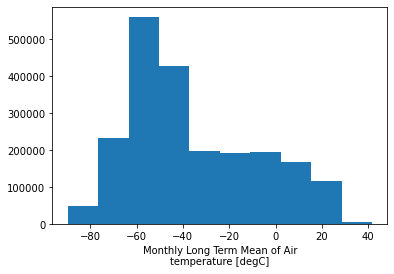

In [4]:
ncep.air.plot()

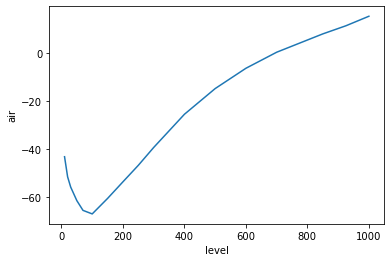

In [15]:
weights = np.cos(np.deg2rad(ncep.lat))

# Use the xarray function to weight the air temperature array
air_weighted = ncep.air.weighted(weights)

# Take the mean over lat/lon/time to get a mean vertical profile
Tglobal = air_weighted.mean(("lat","lon", "time"))
Tglobal.plot()

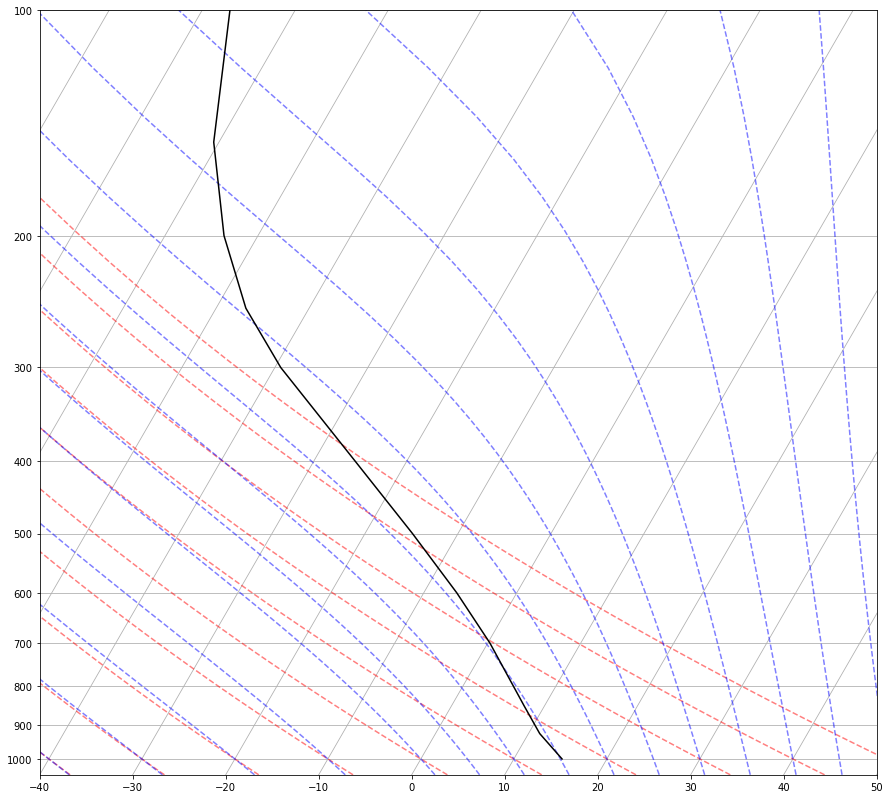

In [14]:
#  a "quick and dirty" visualization of the data
fig = plt.figure(figsize=(15,15))
skew = SkewT(fig, rotation=30)
skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-')
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()

**Task 2**: What is the surface temperature with the single layer model? 

In [17]:
# Solve for the atmospheric surface temperature

# Calc surface temperature Ts
# Put you own code here
Ts = Te * 2**(1/4)

print('Surface temperature: {:.2f}'.format(Ts))

Surface temperature: 303.14


Why does the model overestimate the surface temperature?

**Task 4**: Write a Python function for $OLR = U_2 = (1-\epsilon)^2 \sigma T_s^4 + \epsilon(1-\epsilon)\sigma T_0^4 + \epsilon \sigma T_1^4$

In [22]:
def two_layer_model(Ts, T0, T1, epsilon):
    """returns energy flux in """
    sigma = 5.68e-8
    surface = (1-epsilon)**2 * sigma * Ts**4
    layer_0 = epsilon * (1-epsilon) * sigma * T0**4
    layer_1 = epsilon * sigma * T1**4
    return surface + layer_0 + layer_1

**Task 6**: We will tune our model so that it reproduces the observed global mean OLR given observed global mean temperatures. Determine the temperatures for the two-layer model from the following sounding

![alt text](pics/vertical_profile.png "Sounding")

**Task 7**: Find graphically the best fit value of $\epsilon$


Idx of lowest epsilon: 588
Value of lowest epsilon: 0.588


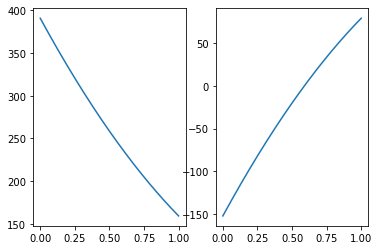

In [30]:
olr_obs = 238.5

epsilons = np.arange(0,1,step=0.001)
olr_list = [two_layer_model(288,275,230,epsilon) for epsilon in epsilons]
olr_res_list = [olr_obs - olr for olr in olr_list]

def find_nearest(arr, val):
    idx, _ = min(enumerate(arr), key=lambda x: abs(x[1]-val))
    return idx
    

plt.subplot(1,2,1)
plt.plot(epsilons, olr_list)

plt.subplot(1,2,2)
plt.plot(epsilons, olr_res_list)

idx_best = find_nearest(olr_list, olr_obs)
print(f'Idx of lowest epsilon: {idx_best}')
print(f'Value of lowest epsilon: {epsilons[idx_best]}')

In [32]:
# Validate the result
two_layer_model(288,275,230,.588)

238.48901245869286

**Task 8**: Write a Python function to calculate each term in the OLR. Plug-in the observed temperatures and the tuned value for epsilon.

In [33]:
def two_layer_terms(Ts, T0, T1, epsilon):
    """returns energy flux in """
    sigma = 5.68e-8
    surface = (1-epsilon)**2 * sigma * Ts**4
    layer_0 = epsilon * (1-epsilon) * sigma * T0**4
    layer_1 = epsilon * sigma * T1**4
    return surface, layer_0, layer_1

In [45]:
# Calculate terms
terms = two_layer_terms(288,275,230,.588)
print(f'Surface OLR: {terms[0]:.2f}')
print(f'Layer_0 OLR: {terms[1]:.2f}')
print(f'Layer_1 OLR: {terms[2]:.2f}')

Surface OLR: 66.33
Layer_0 OLR: 78.70
Layer_1 OLR: 93.46


**Task 9**: Changing the level of emission by adding absorbers, e.g. by 10 %. 
Suppose further that this increase happens abruptly so that there is no time for the temperatures to respond to this change. We hold the temperatures fixed in the column and ask how the radiative fluxes change.

Which terms in the OLR go up and which go down?

In [52]:
# Make simulation here
terms = two_layer_terms(275,275,275,.588+.1)
print(f'Surface OLR: {terms[0]:.2f}')
print(f'Layer_0 OLR: {terms[1]:.2f}')
print(f'Layer_1 OLR: {terms[2]:.2f}')
print(f'Total OLR: {sum(terms):.2f}')

print('')
terms = two_layer_terms(275,275,275,.588)
print(f'Surface OLR: {terms[0]:.2f}')
print(f'Layer_0 OLR: {terms[1]:.2f}')
print(f'Layer_1 OLR: {terms[2]:.2f}')
print(f'Total OLR: {sum(terms):.2f}')

# same total 

Surface OLR: 31.62
Layer_0 OLR: 69.73
Layer_1 OLR: 223.49
Total OLR: 324.85

Surface OLR: 55.14
Layer_0 OLR: 78.70
Layer_1 OLR: 191.01
Total OLR: 324.85


**Task 10**: Calculate the radiative forcing for the previous simulation

In [58]:
# Calculate radiative forcing

r = - (two_layer_model(288,275,230,.588+.1) - two_layer_model(288,275,230,.588))

print(f'Total radiative forcing: {r:.2f}')

Total radiative forcing: 21.36


**Task 11**: What is the greenhouse effect for an isothermal atmosphere?

In [59]:
# Make simulation here
r = - (two_layer_model(288,288,288,.588+.1) - two_layer_model(288,288,288,.588))

print(f'Total radiative forcing: {r:.2f}')

Total radiative forcing: 0.00


**Task 12**: For a more realistic example of radiative forcing due to an increase in greenhouse absorbers, we use our observed temperatures and the tuned value for epsilon. Assume an increase of epsilon by 2 %.

In [60]:
# Make simulation here
r = - (two_layer_model(288,275,230,.588+ .588*.02) - two_layer_model(288,275,230,.588))

print(f'Total radiative forcing: {r:.2f}')

Total radiative forcing: 2.58
